In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score

In [2]:
import xarray as xr

ds = xr.open_dataset('dataset_precip.nc')

print(ds)


<xarray.Dataset> Size: 15kB
Dimensions:  (time: 730)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2022-01-01T12:00:00 ... 2023-12-31T12:...
Data variables:
    tcwv     (time) float32 3kB ...
    tcc      (time) float32 3kB ...
    tp       (time) float32 3kB ...
Attributes:
    description:    Merged ERA5 and MODIS AOD dataset
    creation_date:  2024-12-29
    time_zone:      UTC
    region:         51E-52E, 35N-36N


In [3]:
import pandas as pd

df = ds.to_dataframe().reset_index()

# print(df.isnull().sum())

df = df.dropna()

#rescale TP to mm/day
df[['tp']] = df[['tp']] * 1000

df

,time,tcwv,tcc,tp
0,2022-01-01 12:00:00,7.131459,0.919266,0.000057
1,2022-01-02 12:00:00,9.397189,1.000000,0.000362
2,2022-01-03 12:00:00,8.124803,0.978844,0.033684
3,2022-01-04 12:00:00,6.060751,0.000000,0.000000
4,2022-01-05 12:00:00,6.495852,0.602828,0.054436
...,...,...,...,...
725,2023-12-27 12:00:00,6.488528,0.000000,0.000000
726,2023-12-28 12:00:00,10.876118,0.658658,0.000000
727,2023-12-29 12:00:00,6.630822,0.075190,0.000191
728,2023-12-30 12:00:00,6.951330,0.003395,0.000000


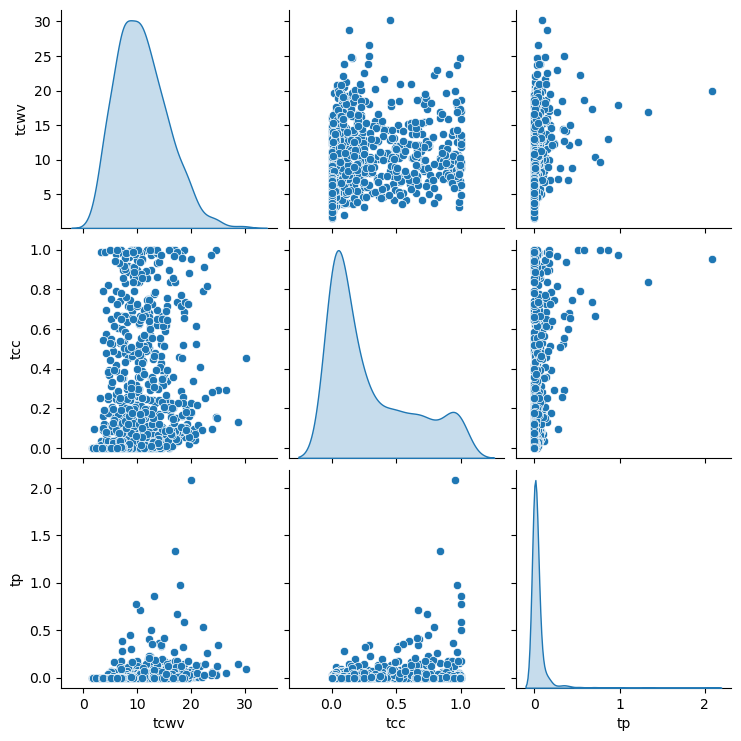

In [4]:
import seaborn as sns

sns.pairplot(df, diag_kind='kde')

In [5]:
#train test split the dataset
from sklearn.model_selection import train_test_split

FEATURES = ['tcwv', 'tcc']

X = df[FEATURES]
y = df[['tp']] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(X_train.shape)
print(X_test.shape)

(584, 2)
(146, 2)


In [6]:

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define the model
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Summary of the model
model.summary()


/Users/admin/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - mae: 0.0615 - val_loss: 0.0106 - val_mae: 0.0614
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0072 - mae: 0.0460 - val_loss: 0.0102 - val_mae: 0.0505
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074 - mae: 0.0384 - val_loss: 0.0100 - val_mae: 0.0479
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - mae: 0.0365 - val_loss: 0.0097 - val_mae: 0.0498
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0308 - val_loss: 0.0101 - val_mae: 0.0634
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0077 - mae: 0.0401 - val_loss: 0.0097 - val_mae: 0.0488
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - mae: 0.0306 - val_loss: 0.0095 - val_mae: 0.0522
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 - mae: 0.0428 - val_loss: 0.0105 - val_mae: 0.0437
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.006

Test MSE: 0.04971500486135483
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
R² Score: 0.034016191959381104


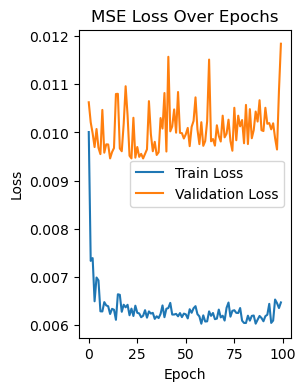

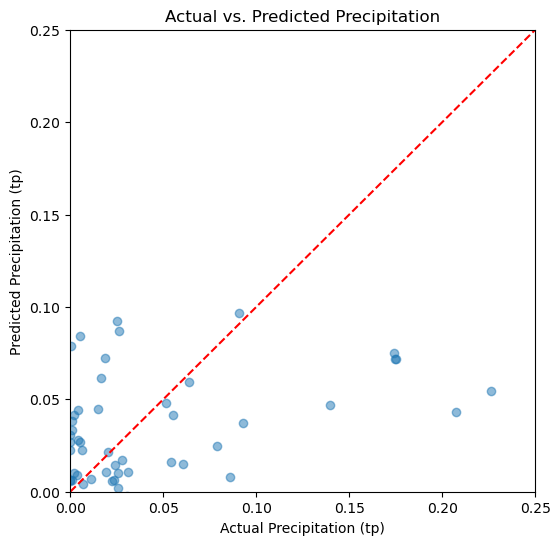

In [9]:
# Evaluate on test data
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f'Test MSE: {loss}')

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2}')

# Plotting training history
plt.figure(figsize=(6, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MSE Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


# Scatter plot of actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
# Set axis limits to 0.25 mm
plt.xlim(0, 0.25)
plt.ylim(0, 0.25)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Precipitation (tp)')
plt.ylabel('Predicted Precipitation (tp)')
plt.title('Actual vs. Predicted Precipitation')
plt.show()
